# Table 1 Force-Field Parameters#
DOI: [10.1103/PhysRevLett.64.1955](https://doi.org/10.1103/PhysRevLett.64.1955)

| $i$-$j$  | A$_{ij}$ (eV)  | b$_{ij}$ (Å$^{-1}$) | c$_{ij}$ (eV Å$^6$) | q$_{i}$  |
|------|------------|----------|------------|------|
| O-O  | 1388.7730  | 2.76     | 175        | -1.2 |
| Si-O | 18003.7572 | 4.87318  | 133.5381   | 2.4  |

# Reduced Units #

We like to use reduced units in our simulations for a few reasons:
1. Units are now order of magnitude of 1, making errors easier to spot.
1. More precision with floating point represnetation near values of 1
1. To take advantage of the [Theorem of corresponding states](https://en.wikipedia.org/wiki/Theorem_of_corresponding_states) (more useful in unary systems)

So in order to get the reduced units for this system, we device by the largest distance

$\mathcal{D} = \frac{1}{2.76Å} = 0.36232 \text{ Å} = 3.6232\text{e-11 m}$

largest mass

$\mathcal{M} = 28.0855 \text{ u } = 4.6637\text{e-26 Kg }  (\text{mass of Si})$

and largest energy

$\mathcal{E} = 18003.7572 \text{ eV} = 2.8845\text{e-}15 \text{ J}$

With these units we can derive the other units in our simulation:
* Time: $\tau = \sqrt{\frac{\mathcal{M} \mathcal{D}^2}{\mathcal{E}}} = 1.4568\text{e-16 s}$
* Volume:
* Velocity:
* Momentum:
* Acceleration:
* Force:
* Pressure:

"HOOMD-blue accepts all temperature inputs and provides all temperature output values in units of energy: $kT$, where $k$ is Boltzmann’s constant. When using physical units, the value $k_B$ is determined by the choices for distance, energy, and mass. In reduced units, one usually reports the value:"

$T^* = \frac{k T}{\mathcal{E}}$


So, 1 unit of dimensionless temperature T corresponds to $\frac{\mathcal{E}}{k_B}$ = 208923557 K,

Our time unit is smaler than most MD simulations, but our distance unit is also pretty small for the MD simulations I normally do. Now we need to use our base units to convert table 1.

| $i$-$j$  | A$_{ij}$ ($\mathcal{E}$)  | b$_{ij}$ ($\mathcal{D}^{-1}$) | c$_{ij}$ ($\mathcal{E} \mathcal{D}^6$) | q$_{i}$  |
|------|------------|----------|------------|------|
| O-O  | 0.07714 | 1        | 4.2966       | -1.2 |
| Si-O | 1       | 0.56636  | 3.2785   | 2.4  |


Now its simulation time!
We will use [HOOMD-blue](http://glotzerlab.engin.umich.edu/hoomd-blue/) as our MD engine. To learn about how to get HOOMD-blue, click [here](https://nbviewer.jupyter.org/github/joaander/hoomd-examples/blob/master/index.ipynb). To learn about to use use HOOMD-blue, click [here](https://bitbucket.org/glotzer/hoomd-examples).

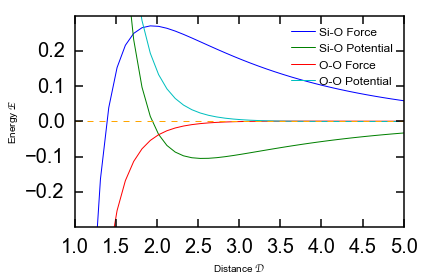

In [109]:
%load_ext autoreload
import warnings
warnings.filterwarnings('ignore')
import sys
import gsd
import gsd.fl
import gsd.hoomd
import os
import random
import hoomd
import hoomd.deprecated
import hoomd.md
import numpy as np
import matplotlib.pyplot as plt
from cme_utils.analyze import diffractometer
%matplotlib inline
%autoreload 2
# Lets take a look at what our FF looks like

def psudo_Buckingham(A, b, c, r):
    F = A*np.exp(-b*r) - (c/r**6)
    V = -A*b*np.exp(-b*r) + ((6*c)/r**7)
    return (F,V)

x = np.linspace(0,10,100)

A_SiO = 1
b_SiO = 0.56636
c_SiO = 3.2785

F_SiO, V_SiO = psudo_Buckingham(A_SiO, b_SiO, c_SiO, x)

A_OO = 0.07714
b_OO = 1
c_OO = 3.2785 

F_OO, V_OO = psudo_Buckingham(A_OO, b_OO, c_OO, x)

plt.plot(x, F_SiO, label = "Si-O Force", linewidth=1)
plt.plot(x, V_SiO, label = "Si-O Potential", linewidth=1)

plt.plot(x, F_OO, label = "O-O Force", linewidth=1)
plt.plot(x, V_OO, label = "O-O Potential", linewidth=1)

plt.xlim(1,5)
plt.ylim(-.3,.3)
plt.axhline(color='orange', ls="--", linewidth=1)
plt.xlabel(r"Distance $\mathcal{D}$")
plt.ylabel(r"Energy $\mathcal{E}$")
plt.legend()


Few thinsg to note about this potential:
1. Gets very steep very fast, at a distance of .1, the potential energy is 1.833e8
1. The potential does not get close to zero, even at a distance of 10, the potential for Si-O is -0.00196. This results in a disconinuity in the force and can cause the system to be unstable and have unphysical dynamics. We either need to apply a smoothing function or have a larger r_cut
1. Further, the Si-O potnetial seems to be "longer range" indicating that we might want to have different r_cuts for Si-O and O-O, below I plotted the potential out to 20 distance units ~7.25 angstroms

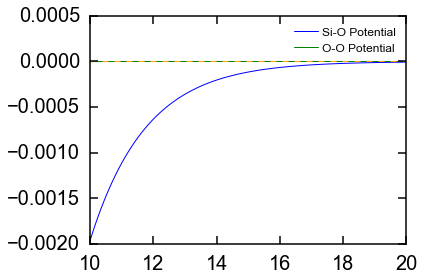

In [155]:
x = np.linspace(10,20,100)
F_SiO, V_SiO = psudo_Buckingham(A_SiO, b_SiO, c_SiO, x)
F_OO, V_OO = psudo_Buckingham(A_OO, b_OO, c_OO, x)

plt.plot(x, V_SiO, label = "Si-O Potential", linewidth=1)
plt.plot(x, V_OO, label = "O-O Potential", linewidth=1)

plt.xlim(10,20)
plt.ylim(-.002,.0005)
plt.axhline(color='orange', ls="--", linewidth=1)
plt.legend(loc="best")

In [99]:
# 2.196 (amorphous) g·cm−3 
# Haynes, William M., ed. (2011). CRC Handbook of Chemistry and Physics (92nd ed.). 
# Boca Raton, FL: CRC Press. ISBN 1439855110.

5.0505050505050502

In [139]:
n = -1
x = np.linspace(0,10,100)
print("%1.3e" % V_SiO[n])
print(V_SiO[n])

-1.963e-03
-0.00196330344626


In [106]:
print(psudo_Buckingham(A_SiO, b_SiO, c_SiO, .7))

(-27.1940876323123, 238.47720987173372)


In [98]:
print(0.00223969161355*(1/28.0855)*(1/6.022e23)*(1/3.6232e-11**3)*(1/1000000))

0.00278412281777796


In [144]:
2.8845e-15/1.38064852e-23

208923557.17007542

In [146]:
7000/208923557

3.3505077649046534e-05

In [22]:
(1/4.87318)/0.36232

0.5663634768320199

In [26]:
div = 18003.7572*(0.36232**6)
div

40.73024227760546

In [14]:
sys.version_info

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)

In [19]:
# Notebook needs to use the CPU
hoomd.context.initialize("--mode=cpu")

if sys.version_info[0] < 3:
    raise "Must be using Python 3"

M_Si = 28.0855 # u
M_O = 15.999 # u

M = 28.0855 # base mass unit

u_2_g = 1.6605e-24 # conversion 1 u to g
cm_2_m = 0.01
D = 3.6232e-11 # m

test = False

if test:
    N_Si = 2#36
    N_O = 4#72
else:
    N_Si = 36*2
    N_O = 72*2
    
assert N_Si*2 == N_O, "Need stoichiometric ratio"
N = N_Si + N_O


# Density Stuff
# 2.196 (amorphous) g·cm−3 
# Haynes, William M., ed. (2011). CRC Handbook of Chemistry and Physics (92nd ed.). 
# Boca Raton, FL: CRC Press. ISBN 1439855110.



mass = M_Si*N_Si*u_2_g + M_O*N_O*u_2_g # grams
rho = 2.196 # g·cm−3 

L = (mass/rho)**(1/3) # cm
L = L * cm_2_m # m
L = L / D # D (diminsonless lenght units)

print("Box size (D): ", L)
print("Starting at a rho of {}, shrining to a rho of {}".format(rho, rho))



# For now we will just use a cubic cell, but we can later use a alpha or beta unitcell
snap = hoomd.data.make_snapshot(N=N, box=hoomd.data.boxdim(L=L), particle_types=['Si', 'O'])
# Set type, default is type 0 = Si, but just being explicit
snap.particles.typeid[:N_Si] = [0]*N_Si
snap.particles.typeid[-N_O:] = [1]*N_O
# Set mass
snap.particles.mass[:N_Si] = [M_Si/M]*N_Si
snap.particles.mass[-N_O:] = [M_O/M]*N_O
# Set charge
snap.particles.charge[:N_Si] = [2.4]*N_Si
snap.particles.charge[-N_O:] = [-1.2]*N_O
# Set pos (just random for now)
point_list =[]
random.seed(0)
for _ in range(N):
    x = random.uniform(-L/2.0, L/2.0)
    y = random.uniform(-L/2.0, L/2.0)
    z = random.uniform(-L/2.0, L/2.0)
    point_list.append([x, y, z])
snap.particles.position[:] = point_list

#print(snap.particles.typeid)
#print(snap.particles.mass)
#print(snap.particles.charge)

system = hoomd.init.read_snapshot(snap)
#http://som.web.cmu.edu/structures/S097-alpha-quartz.html
#http://homepage.univie.ac.at/michael.leitner/lattice/struk.xmol/sio2a.pos
uc = hoomd.lattice.unitcell(N = 2,
                            a1 = [ 4.9137,0,0],
                            a2 = [0, 4.9137,0],
                            a3 = [0,0,  5.4047],
                            dimensions = 3,
                            position = [[0.4697,0,0],
                                        [ 0.4133,  0.2672,  0.1188]],
                            type_name = ['Si', 'O'],
                            mass = [M_Si/M, M_O/M],
                            charge = [2.4, -1.2])



hoomd.dump.gsd(filename="start.gsd", period=None, group=hoomd.group.all(), overwrite=True)

print("Tota mass (M): ", sum(snap.particles.mass))
print("Volume (D**3): ", system.box.get_volume())
print("Density (M*D**-3): ", sum(snap.particles.mass)/system.box.get_volume())


def my_pair_potential(r, rmin, rmax, A, b, c):
    F = A*np.exp(-b*r) - (c/r**6)
    V = -A*b*np.exp(-b*r) + ((6*c)/r**7)
    return (V,F)


A_SiO = 1
b_SiO = 0.56636
c_SiO = 3.2785

A_OO = 0.07714
b_OO = 1
c_OO = 3.2785 

nl = hoomd.md.nlist.cell()

table = hoomd.md.pair.table(width=int(1e4), nlist=nl)
table.pair_coeff.set('Si', 'O', func=my_pair_potential, rmin=0.7, rmax=20.0, coeff=dict(A=A_SiO, b=b_SiO, c=c_SiO))
table.pair_coeff.set('O', 'O', func=my_pair_potential, rmin=0.7, rmax=20.0, coeff=dict(A=A_OO, b=b_OO, c=c_OO))
#table.pair_coeff.set('Si', 'Si', func=my_pair_potential, rmin=0.7, rmax=20.0, coeff=dict(A=0, b=0, c=0))
table.pair_coeff.set('Si', 'Si', func=my_pair_potential, rmin=0.7, rmax=20.0, coeff=dict(A=0, b=0, c=0))

charged = hoomd.group.charged()
pppm = hoomd.md.charge.pppm(group=charged,  nlist=nl)
pppm.set_params(Nx=64, Ny=64, Nz=64, order=6, rcut=15.18)

hoomd.md.integrate.mode_standard(dt=0.001)
hoomd.md.integrate.nvt(group=hoomd.group.all(), kT=.0, tau=5)






hoomd.analyze.log(filename="log-output.log",
                  quantities=['potential_energy', 'temperature'],
                  period=100,
                  overwrite=True)

hoomd.dump.gsd(filename="out.gsd", period=100, group=hoomd.group.all(), overwrite=True)
hoomd.run(1e4)
print("Done")

Box size (D):  40.97061159308718
Starting at a rho of 2.196, shrining to a rho of 2.196
notice(2): Group "all" created containing 216 particles
Tota mass (M):  154.030088425
Volume (D**3):  68772.90047100719
Density (M*D**-3):  0.00223969161355
notice(2): Group "charged" created containing 216 particles
-----
You are using PPPM. Please cite the following:
* D N LeBard, B G Levine, S A Barr, A Jusufi, S Sanders, M L Klein, and A Z
  Panagiotopoulos. "Self-assembly of coarse-grained ionic surfactants
  accelerated by graphics processing units", Journal of Computational Physics 8
  (2012) 2385-2397
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 216
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
notice(2): charge.pppm: RMS error: 1.20367e-08
Time 00:00:10 | Step 98 / 10000 | TPS 9.73887 | ETA 00:16:56
Time 00:00:20 | Step 201 / 10000 | TPS 10.

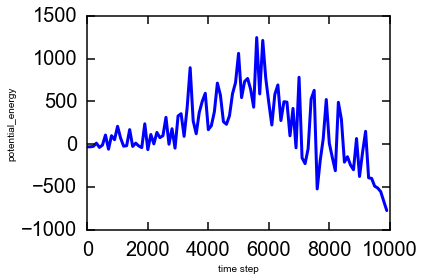

In [34]:
# Here we will read in the log file
data = np.genfromtxt(fname='log-output.log', skip_header=True)

# Now we use the first col as the x and the 2nd col as the y
plt.plot(data[:,0], data[:,1])

plt.xlabel('time step')
plt.ylabel('potential_energy')
plt.show()

In [53]:
x = np.array([0,1,2,3,4,5])

In [56]:
x[:2]

array([0, 1])

In [61]:
x[-4:]

array([2, 3, 4, 5])

In [91]:
dir(system.box.get_volume)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [93]:
system.box.get_volume()

34386.45023550358

In [142]:
def diffract_last_frame(fname, typeId=2):
    f = gsd.fl.GSDFile(fname, 'rb')
    t = gsd.hoomd.HOOMDTrajectory(f)
    n_frames = len(t)
    end_frame = n_frames-1
    snapshot = t[end_frame]
    sim_box = snapshot.configuration.box
    box_dim=(sim_box[0], sim_box[1], sim_box[2])
    box_dim = np.array(box_dim)
    print('box_dim',box_dim)
    l_pos = snapshot.particles.position
    pos = l_pos[np.where(snapshot.particles.typeid == typeId)]
    diffract_dir = './{}_diffract_type_{}'.format(fname, typeId)
    if not os.path.exists(diffract_dir):
            os.makedirs(diffract_dir)
    D = diffractometer.diffractometer(working_dir=diffract_dir)
    D.set(grid_size=512,  peak_width=1, zoom=8, n_views=20, length_scale=0.36232,bot=1e-5,top=1)
    D.load(pos,box_dim)
    D.prep_matrices()
    D.average()

In [4]:
#diffract_last_frame("pout.gsd", typeId=0)

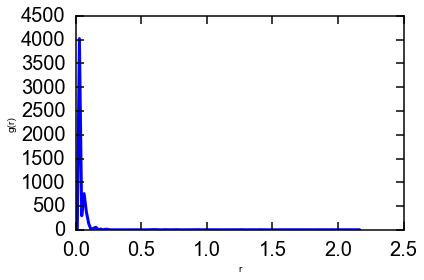

In [58]:
import hoomd
import hoomd.md
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from freud import parallel, box, density
import gsd
import gsd.hoomd
import gsd.fl
parallel.setNumThreads(4)


def plot_rdf(file, frames, rmax, label):
    # frames is the number of frames you want to average over starting from
    # the last frame
    rdf = density.RDF(rmax=rmax, dr=0.05)
    f = gsd.fl.GSDFile(file, 'rb')
    t = gsd.hoomd.HOOMDTrajectory(f)
    for i in range(1, frames):
        sim_box = t[-i].configuration.box
        fbox = box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
        pos = t[-i].particles.position
        rdf.accumulate(fbox, pos, pos)
                       
    r_avg = np.copy(rdf.getR())
    y_avg = np.copy(rdf.getRDF())
    plt.plot(r_avg*0.36232, y_avg, label=label)
    plt.ylabel("g(r)")
    plt.xlabel("r")
    
    
    
plot_rdf('out.gsd', 2, 6, "kT = 1.0")

In [59]:
import gsd
import gsd.fl
import gsd.hoomd
from freud import parallel, box, density
import numpy as np


def getRDFFromGSD(gsdFileName,
            type1,
            type2,
            rmax=None,
            dr=0.1,
            nFrames=10,
            type1_COM=False,
            type1_N=1,
            type2_COM=False,
            type2_N=1):
    '''
    Creates an averaged RDF over the last N frames given by nFrames for type1 and type2.
    If type1 or type2 is a bead chain rather than single particles, type<#>_COM flag
    allows user to use the center of mass of the bead chain of length type<#>_N.

    Arguments:
    type1: typeid of the first particle type (integer)
    type2: typeid of the second particle type (integer)
    rmax: Sets the maximum distance to calculate RDF for. If set to None, we automatically choose
    L/2 as rmax. Default: None
    dr: Sets the interval of distance at which RDF is evaluated. Control the resolution of the RDF. Default: 0.1
    nFrames: Sets the number of frames over which the RDF is averaged. The algorithms picks up the
    last nFrames based on this value.
    type1_COM,type2_COM: Specifies if the particle type is a bead chain and hence need to use the center
    of mass than the position of a single bead. This assumes that the bead chain just consists of
    beads of a single type and is of length type1_N or type2_N respectively.

    Returns: An rdf object defined in the freud library(http://glotzerlab.engin.umich.edu/freud/density.html#freud.density.RDF)
    '''
    f = gsd.fl.GSDFile(gsdFileName, 'rb')
    t = gsd.hoomd.HOOMDTrajectory(f)
    if rmax is None and len(t) > 0:
        snapshot = t[0]
        sim_box = snapshot.configuration.box
        rmax = sim_box[0]/2
    rdf = density.RDF(rmax=rmax, dr=dr)
    rdf.resetRDF()
    n_frames = len(t)
    end_frame = n_frames-1
    start_frame=end_frame-nFrames
    print('RDF will be calulated from frame {} to {}. Available frames are from {} to {}.'.format(start_frame,end_frame,0,n_frames-1))
    box_dim=(sim_box[0], sim_box[1], sim_box[2])
    box_dim = np.array(box_dim)
    print('box_dim',box_dim)
    #iterate over the frames to calculate average
    for i in range(start_frame, end_frame+1):
        snapshot = t[i]
        sim_box = snapshot.configuration.box
        fbox = box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
        l_pos = snapshot.particles.position
        l_masses = snapshot.particles.mass
        l_images = snapshot.particles.image
        type1_pos = l_pos[np.where(snapshot.particles.typeid == type1)]
        type2_pos = l_pos[np.where(snapshot.particles.typeid == type2)]
        if type1_COM is True:
            type1_masses = l_masses[np.where(snapshot.particles.typeid == type1)]
            COMS = []
            for positions,masses in zip(batch_gen(type1_pos, type1_N),
                                               batch_gen(type1_masses,type1_N)):
                unwrapped_pos = convert.pbc_traslate(positions,box_dim)
                COM = [calcCOM(unwrapped_pos,masses)]
                wrappedCOM,thisImage = pbc.shift_pbc(COM,box_dim)
                COMS.append(wrappedCOM[0]) #COM
            type1_pos = np.array(COMS,dtype=np.float32)
        if type2_COM is True:
            type2_masses = l_masses[np.where(snapshot.particles.typeid == type2)]
            COMS = []
            for positions,masses in zip(batch_gen(type2_pos, type2_N),
                                               batch_gen(type2_masses,type2_N)):
                unwrapped_pos = convert.pbc_traslate(positions,box_dim)
                COM = [calcCOM(unwrapped_pos,masses)]
                wrappedCOM,thisImage = pbc.shift_pbc(COM,box_dim)
                COMS.append(wrappedCOM[0]) #COM
                #print('wrapped p',positions,'\nunwrapped ps',unwrapped_pos)
                #print('unwrapped COM',COM,'wrapped COM',wrappedCOM)
            type2_pos = np.array(COMS,dtype=np.float32)
        rdf.accumulate(fbox, type1_pos, type2_pos)
    return rdf

RDF will be calulated from frame 89 to 99. Available frames are from 0 to 99.
box_dim [ 40.97061157  40.97061157  40.97061157]


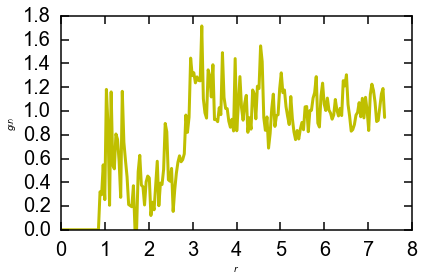

In [33]:
rdf = getRDFFromGSD('out.gsd',type1=0,type2=0,nFrames=10,dr=0.1)
r=rdf.getR()
gr =rdf.getRDF()
plt.xlabel(r"$r$")
plt.ylabel(r"$g\left(r\right)$")
#plt.ylim(0,maxY)
plt.legend(fontsize=20)
plt.plot(r*0.36232,gr,label='Si-Si',color='y')
plt.show()

In [35]:
0.36232*20

7.2463999999999995

In [124]:
hoomd.context.initialize("--mode=cpu")
system = hoomd.deprecated.init.read_xml(filename="dftshift.hoomdxml")
#system.replicate(nx=10,ny=10,nz=10)
#hoomd.deprecated.dump.xml(group=hoomd.group.all(), filename="full.hoomdxml", all=True)
hoomd.dump.gsd(filename="full.gsd", truncate=True, group=hoomd.group.all(), period=None)

notice(2): Reading dftshift.hoomdxml...
notice(2): --- hoomd_xml file read summary
notice(2): 243 positions at timestep 0
notice(2): 243 images
notice(2): 243 masses
notice(2): 243 diameters
notice(2): 2 particle types
notice(2): 243 particle body values


*Warning*: pos 4:-3.566086 6.4518 7.204616
*Warning*: fractional pos :0.261559584696 1.17224857445 0.938354597453
*Warning*: lo: -7.4779395 -7.477969 -8.2177945
*Warning*: hi: 7.4779395 7.477969 8.2177945
*Warning*: Not all particles were found inside the given box


RuntimeError: Error initializing ParticleData

RDF will be calulated from frame -10 to 0. Available frames are from 0 to 0.
box_dim [  98.26799774   98.26799774  108.10399628]


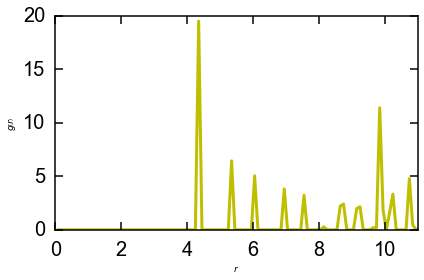

In [62]:
rdf = getRDFFromGSD('full.gsd',type1=0,type2=0,nFrames=10,dr=0.1)
r=rdf.getR()
gr =rdf.getRDF()
plt.xlabel(r"$r$")
plt.ylabel(r"$g\left(r\right)$")
#plt.ylim(0,maxY)
plt.legend(fontsize=20)
plt.plot(r,gr,label='Si-Si',color='y')
plt.xlim(0,11)
plt.show()

In [57]:
2.45670000*2

4.9134

In [40]:
4.25512922*2

8.51025844

In [41]:
5.40520*2

10.8104

In [43]:
4.24524408*2

8.49048816

In [44]:
1.99948522*2

3.99897044

In [45]:
2.30880666*2

4.61761332

In [46]:
# pbc set {9.8268 9.8268 10.8104 90 90 120}

In [48]:
lx="9.8268" ly="9.8268" lz="10.8104" 

SyntaxError: invalid syntax (<ipython-input-48-b0fcdb49251f>, line 1)

In [52]:
# pbc set {14.955879 14.955938 16.435589 90 90 120}

In [63]:
box lx="14.955879" ly="14.955938" lz="16.435589" xy="0" xz="0" yz="-.5"

SyntaxError: invalid syntax (<ipython-input-63-fcee60b65ca0>, line 1)

In [70]:
(36*2)

72

In [71]:
3*3**3

81

In [77]:
# pbc set {18 18 20 90 90 120}

In [78]:
import mdtraj

In [79]:
tj = mdtraj.load_hoomdxml("dftsio2.hoomdxml")

In [80]:
 mdtraj.compute_center_of_mass(tj)

array([[ nan,  nan,  nan]])

In [81]:
tj

<mdtraj.Trajectory with 1 frames, 243 atoms, 243 residues, and unitcells at 0x113525470>

In [113]:
#tj.xyz

In [87]:
tj.center_coordinates()

<mdtraj.Trajectory with 1 frames, 243 atoms, 243 residues, and unitcells at 0x113525470>

In [114]:
#tj.xyz

In [89]:
tj.save_pdb("out.pdb", force_overwrite=True, bfactors=None)

In [95]:
from cme_utils.manip import utilities

In [115]:
#aadic = utilities.loadMorphologyXML("dftsio2.hoomdxml", sigma=1.0)
#for xyz in aadic['position']:
#    print(xyz)

In [123]:
aadic = utilities.loadMorphologyXML("dftsio2.hoomdxml", sigma=1.0)
for atom_id, xyz in enumerate(aadic['position']):
    aadic['position'][atom_id] = np.array(xyz) + np.array([0.1, 0.1, -.1])
utilities.writeMorphologyXML(aadic, "dftshift.hoomdxml", check_inputs = False)

XML file written to dftshift.hoomdxml!


In [106]:
aadic = utilities.loadMorphologyXML("dftsio2.hoomdxml", sigma=0.36232)
utilities.writeMorphologyXML(aadic, "dftshift.hoomdxml")

Checking wrapped positions before writing XML...
XML file written to dftshift.hoomdxml!
